<a href="https://colab.research.google.com/github/DRepresser/NeuroClassify/blob/main/ESM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## setup colab

In [ ]:
pip install -q biopython fair-esm torch matplotlib seaborn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.3 MB/s eta 0:00:00


In [ ]:
from Bio import SeqIO
import pandas as pd
import torch
import esm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm

## load fasta data

In [ ]:
# Function to read sequences from a FASTA file
def read_fasta(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append({"id": record.id, "sequence": str(record.seq)})
    return pd.DataFrame(sequences)

In [ ]:
# Paths to your datasets
train_pos_path = '/content/drive/MyDrive/ESM/data_raw/PLM_Train_pos.fasta'
train_neg_path = '/content/drive/MyDrive/ESM/data_raw/PLM_Train_neg.fasta'
test_pos_path = '/content/drive/MyDrive/ESM/data_raw/PLM_Test_pos.fasta'
test_neg_path = '/content/drive/MyDrive/ESM/data_raw/PLM_Test_neg.fasta'

# Reading datasets
train_pos_df = read_fasta(train_pos_path)
train_neg_df = read_fasta(train_neg_path)
test_pos_df = read_fasta(test_pos_path)
test_neg_df = read_fasta(test_neg_path)

# Add labels: 1 for neuropeptides (pos), 0 for non-neuropeptides (neg)
train_pos_df['label'] = 1
train_neg_df['label'] = 0
test_pos_df['label'] = 1
test_neg_df['label'] = 0

In [ ]:
# Combine training and test datasets
train_df = pd.concat([train_pos_df, train_neg_df], ignore_index=True)
test_df = pd.concat([test_pos_df, test_neg_df], ignore_index=True)

In [ ]:
# Show the structure of the dataset
print(train_df.head())
print()
print(len(train_df))

        id                                  sequence  label
0  PLM_pos                                  IKDNFIRF      1
1  PLM_pos                              QERRAMGFVGMR      1
2  PLM_pos             APVSTGAGGGTVLAKMYPRGSHWAVGHLM      1
3  PLM_pos  SYSMEHFRWGKPVGRKRRPVKVYTSNGVEEESAEVFPGEM      1
4  PLM_pos                                RGPSGPLRFG      1

8038


## EDA

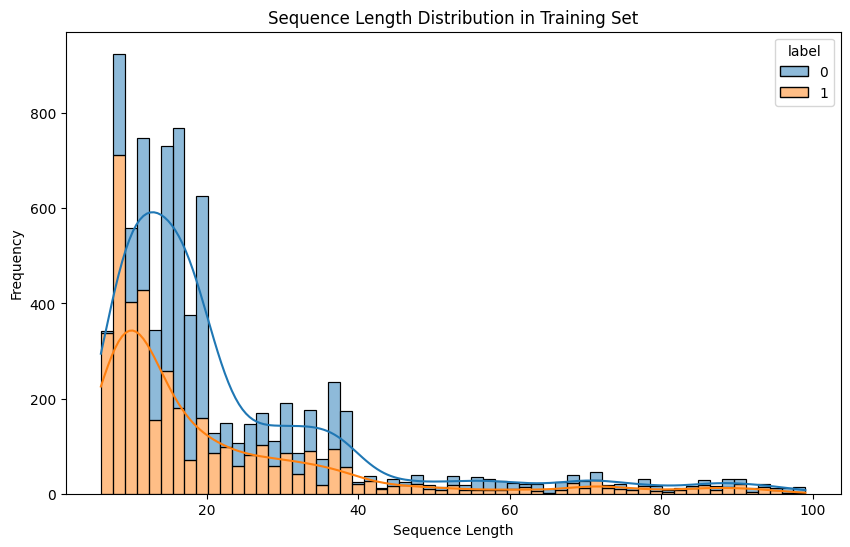

In [ ]:
# Add sequence length to the DataFrame
train_df['length'] = train_df['sequence'].apply(len)
test_df['length'] = test_df['sequence'].apply(len)

# Plot sequence length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='length', hue='label', kde=True, multiple='stack')
plt.title("Sequence Length Distribution in Training Set")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

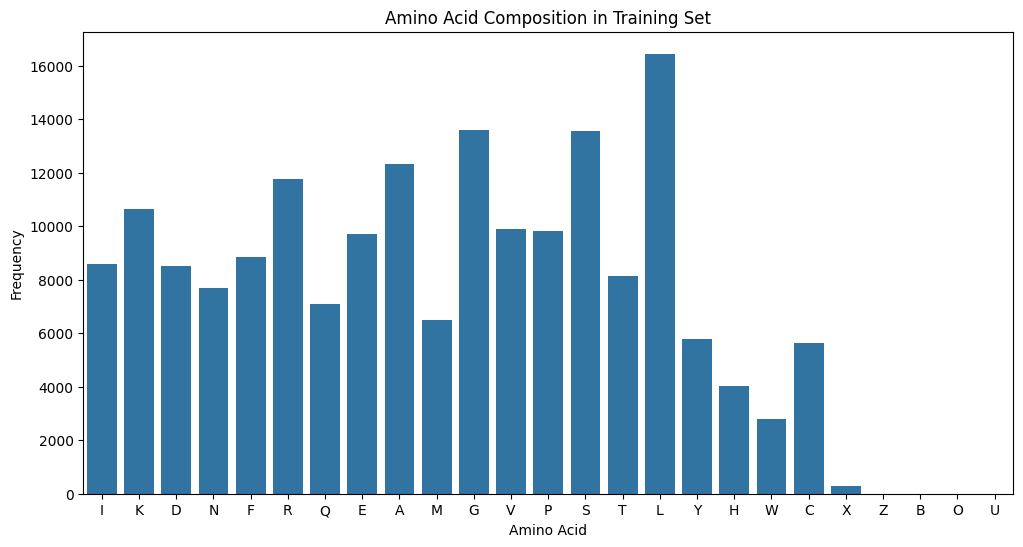

In [ ]:
# Combine all sequences in the training set
all_train_sequences = ''.join(train_df['sequence'])
aa_counts = Counter(all_train_sequences)

# Convert to DataFrame for visualization
aa_df = pd.DataFrame(list(aa_counts.items()), columns=['Amino Acid', 'Count'])

# Plot amino acid composition
plt.figure(figsize=(12, 6))
sns.barplot(x='Amino Acid', y='Count', data=aa_df)
plt.title("Amino Acid Composition in Training Set")
plt.xlabel("Amino Acid")
plt.ylabel("Frequency")
plt.show()

## model

In [ ]:
# Load the ESM model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
batch_converter = alphabet.get_batch_converter()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


In [ ]:
model

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [ ]:
# Function to extract features using ESM
def extract_esm_features(df, batch_size=10):
    all_embeddings = []

    for i in tqdm(range(0, len(df), batch_size)):
        batch_sequences = df.iloc[i:i+batch_size]
        data = [(row['id'], row['sequence']) for _, row in batch_sequences.iterrows()]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)

        # Move batch tokens to GPU
        batch_tokens = batch_tokens.to(device)

        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[33])
            token_embeddings = results["representations"][33]

        # Move embeddings back to CPU and process them
        for i, (_, seq) in enumerate(data):
            embedding = token_embeddings[i, 1 : len(seq) + 1].mean(0).cpu().numpy()  # Mean over sequence length
            all_embeddings.append(embedding)

    return np.array(all_embeddings)

In [ ]:
train_features = extract_esm_features(train_df)

100%|██████████| 804/804 [03:59<00:00,  3.35it/s]


In [ ]:
train_features.shape

(8038, 1280)

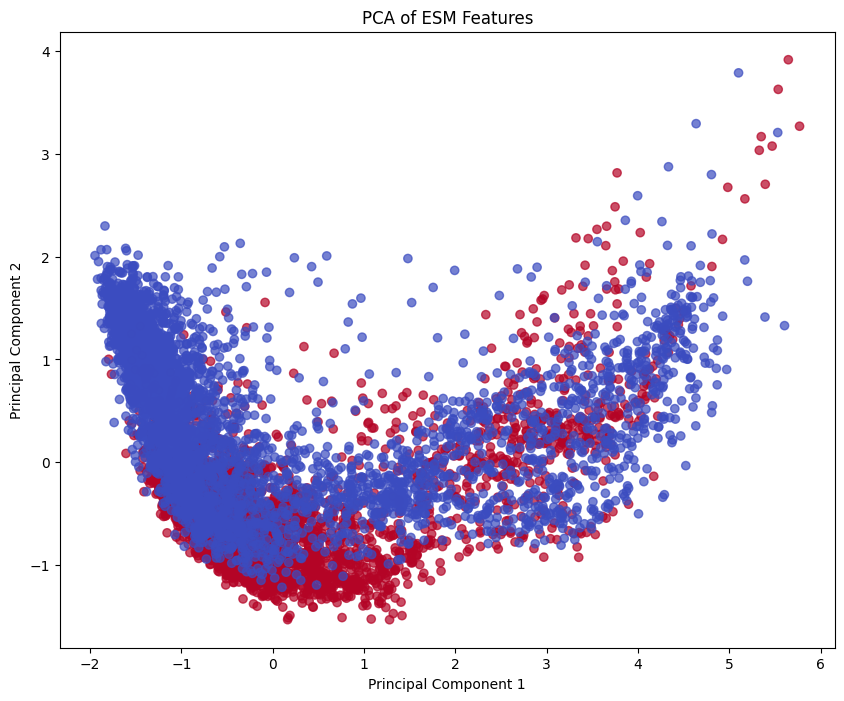

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the feature dimensionality
pca = PCA(n_components=2)
train_reduced_features = pca.fit_transform(train_features)

# Visualize the reduced features
plt.figure(figsize=(10, 8))
plt.scatter(train_reduced_features[:, 0], train_reduced_features[:, 1], c=train_df['label'], cmap='coolwarm', alpha=0.7)
plt.title("PCA of ESM Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

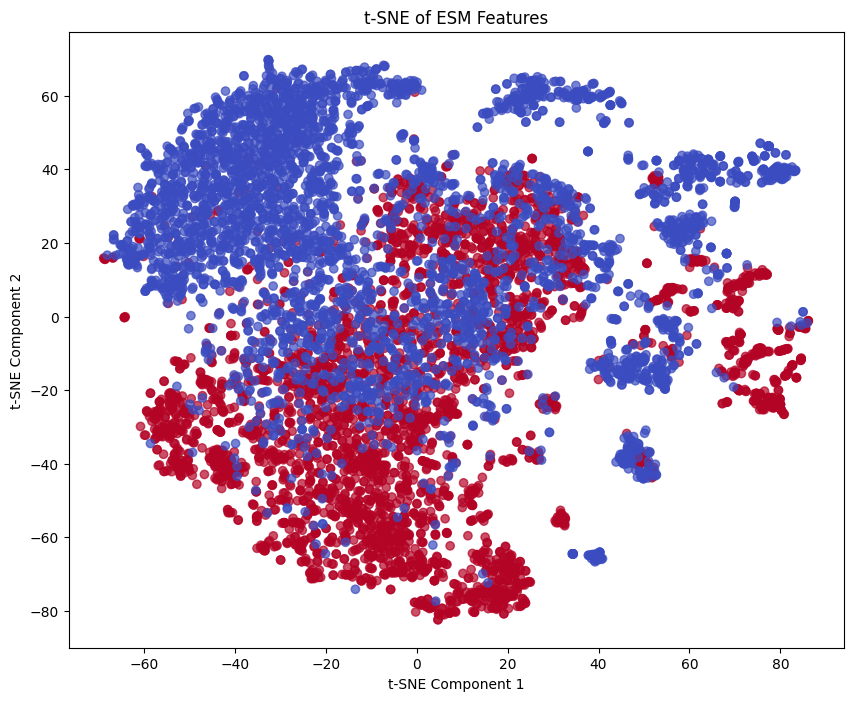

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
train_tsne_features = tsne.fit_transform(train_features)

# Plot t-SNE visualization
plt.figure(figsize=(10, 8))
plt.scatter(train_tsne_features[:, 0], train_tsne_features[:, 1], c=train_df['label'], cmap='coolwarm', alpha=0.7)
plt.title("t-SNE of ESM Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

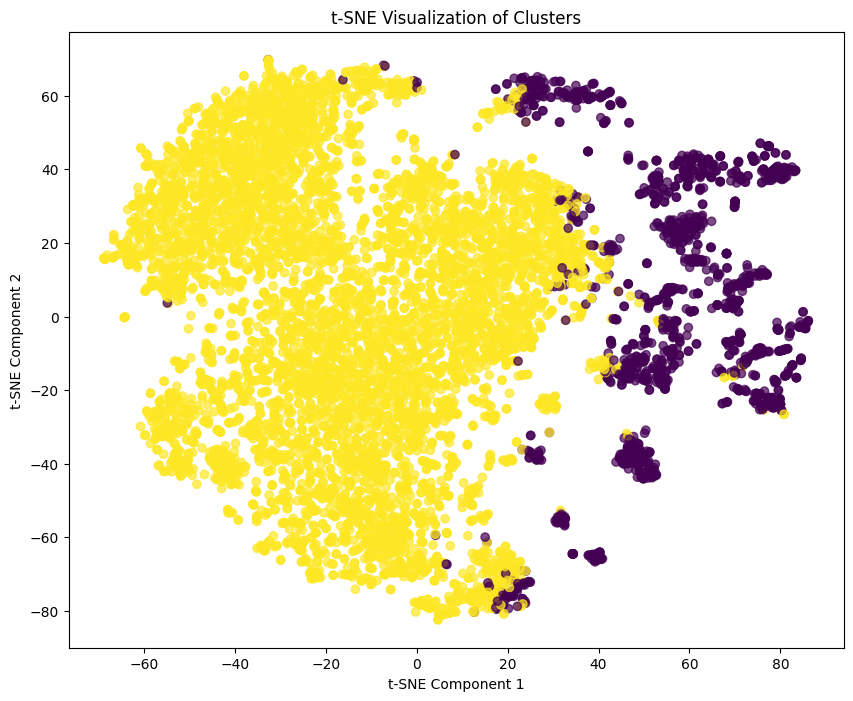

In [ ]:
from sklearn.cluster import KMeans

# Apply K-Means clustering to the ESM features
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(train_features)

# Add the cluster labels to your DataFrame
train_df['cluster'] = cluster_labels

# Visualize clusters using t-SNE
plt.figure(figsize=(10, 8))
plt.scatter(train_tsne_features[:, 0], train_tsne_features[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(train_features)
pca_features

array([[ 0.38812107, -0.8023236 ],
       [-0.72759527, -0.19148333],
       [-0.85269034, -0.44329143],
       ...,
       [ 4.0184913 ,  1.918767  ],
       [-0.42635345,  1.2754526 ],
       [ 2.9797547 ,  0.4395871 ]], dtype=float32)

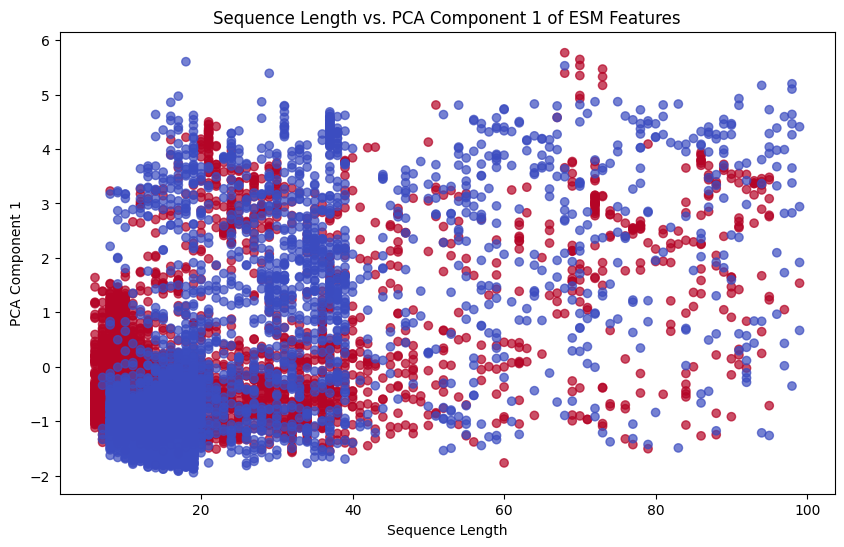

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(train_df['length'], pca_features[:, 0], c=train_df['label'], cmap='coolwarm', alpha=0.7)
plt.title("Sequence Length vs. PCA Component 1 of ESM Features")
plt.xlabel("Sequence Length")
plt.ylabel("PCA Component 1")
plt.show()

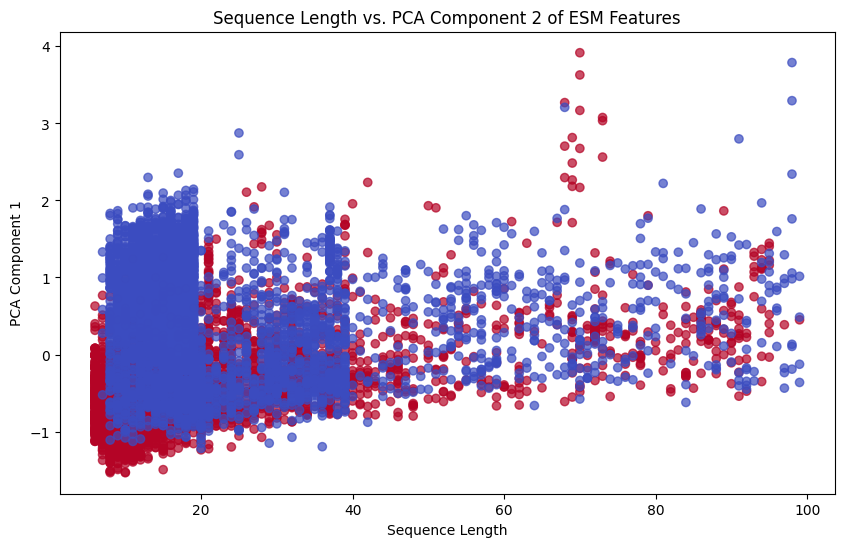

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(train_df['length'], pca_features[:, 1], c=train_df['label'], cmap='coolwarm', alpha=0.7)
plt.title("Sequence Length vs. PCA Component 2 of ESM Features")
plt.xlabel("Sequence Length")
plt.ylabel("PCA Component 1")
plt.show()

In [ ]:
# Define amino acid groups
amino_acid_groups = {
    'hydrophobic': 'AVLIMFWY',
    'hydrophilic': 'RNDQEK',
    'positive': 'RKH',
    'negative': 'DE',
    'polar': 'STNQ',
    'non_polar': 'GAVLIMPWF'
}

# Function to count group occurrences in a sequence
def group_composition(sequence, group_dict):
    group_counts = {group: 0 for group in group_dict}
    for aa in sequence:
        for group, aas in group_dict.items():
            if aa in aas:
                group_counts[group] += 1
    return group_counts

# Apply group analysis to your dataset
train_df['group_composition'] = train_df['sequence'].apply(lambda seq: group_composition(seq, amino_acid_groups))

# Expand the dictionary into separate columns
group_df = pd.json_normalize(train_df['group_composition'])
train_df = pd.concat([train_df, group_df], axis=1)

In [ ]:
train_df

,id,sequence,label,length,cluster,group_composition,hydrophobic,hydrophilic,positive,negative,polar,non_polar
0,PLM_pos,IKDNFIRF,1,8,1,"{'hydrophobic': 4, 'hydrophilic': 4, 'positive...",4,4,2,1,1,4
1,PLM_pos,QERRAMGFVGMR,1,12,1,"{'hydrophobic': 5, 'hydrophilic': 5, 'positive...",5,5,3,1,1,7
2,PLM_pos,APVSTGAGGGTVLAKMYPRGSHWAVGHLM,1,29,1,"{'hydrophobic': 13, 'hydrophilic': 2, 'positiv...",13,2,4,0,4,20
3,PLM_pos,SYSMEHFRWGKPVGRKRRPVKVYTSNGVEEESAEVFPGEM,1,40,0,"{'hydrophobic': 13, 'hydrophilic': 14, 'positi...",13,14,8,6,6,18
4,PLM_pos,RGPSGPLRFG,1,10,1,"{'hydrophobic': 2, 'hydrophilic': 2, 'positive...",2,2,2,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...
8033,PLM_neg,RVLEPGXEDPDVGEPAGEYEHHLLEX,0,26,1,"{'hydrophobic': 7, 'hydrophilic': 9, 'positive...",7,9,3,8,0,12
8034,PLM_neg,MSSAILYRNK,0,10,1,"{'hydrophobic': 5, 'hydrophilic': 3, 'positive...",5,3,2,0,3,4
8035,PLM_neg,NAHNFPLDLGAIEAPSTTG,0,19,0,"{'hydrophobic': 7, 'hydrophilic': 4, 'positive...",7,4,1,2,5,11
8036,PLM_neg,MCVCGVHH,0,8,1,"{'hydrophobic': 3, 'hydrophilic': 0, 'positive...",3,0,2,0,0,4


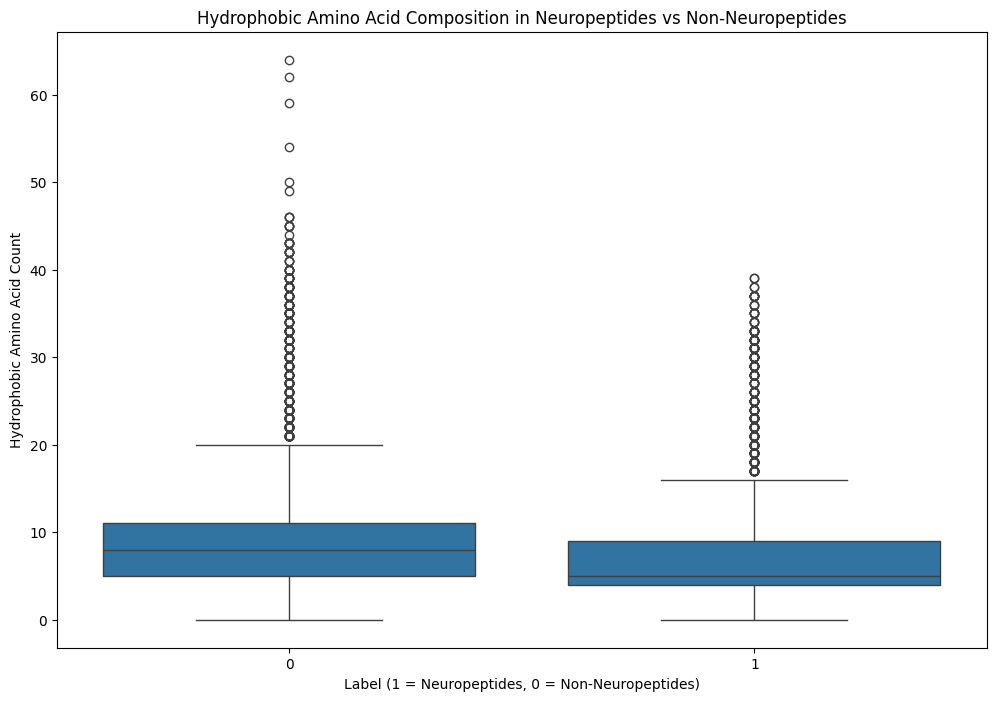

In [ ]:
# Visualize group composition differences between neuropeptides and non-neuropeptides
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_df, x='label', y='hydrophobic')
plt.title('Hydrophobic Amino Acid Composition in Neuropeptides vs Non-Neuropeptides')
plt.xlabel('Label (1 = Neuropeptides, 0 = Non-Neuropeptides)')
plt.ylabel('Hydrophobic Amino Acid Count')
plt.show()

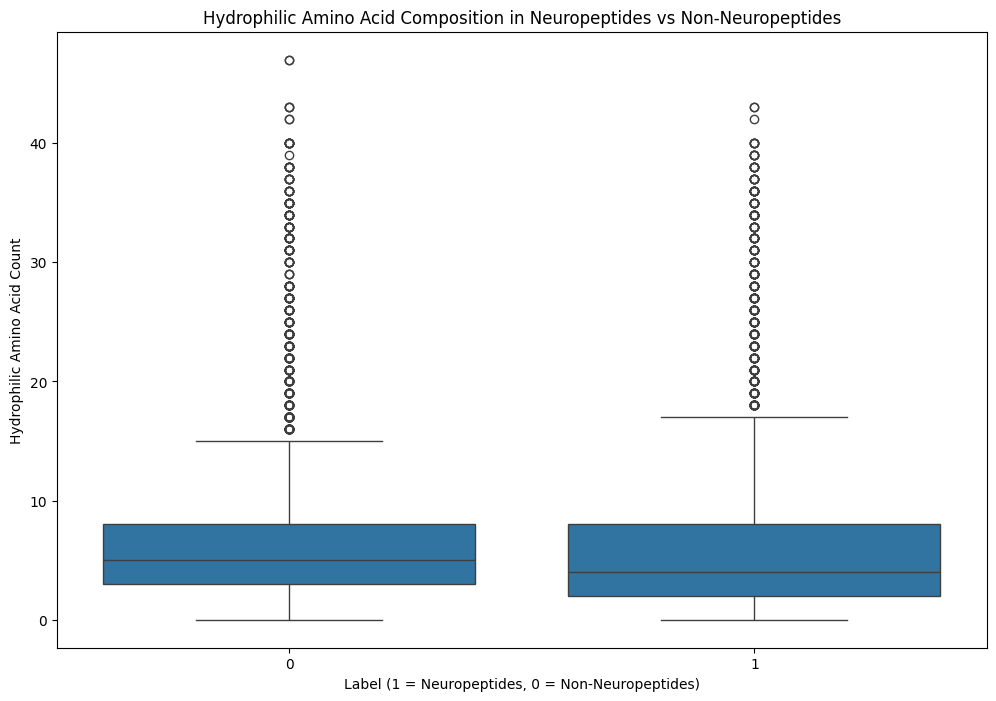

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_df, x='label', y='hydrophilic')
plt.title('Hydrophilic Amino Acid Composition in Neuropeptides vs Non-Neuropeptides')
plt.xlabel('Label (1 = Neuropeptides, 0 = Non-Neuropeptides)')
plt.ylabel('Hydrophilic Amino Acid Count')
plt.show()

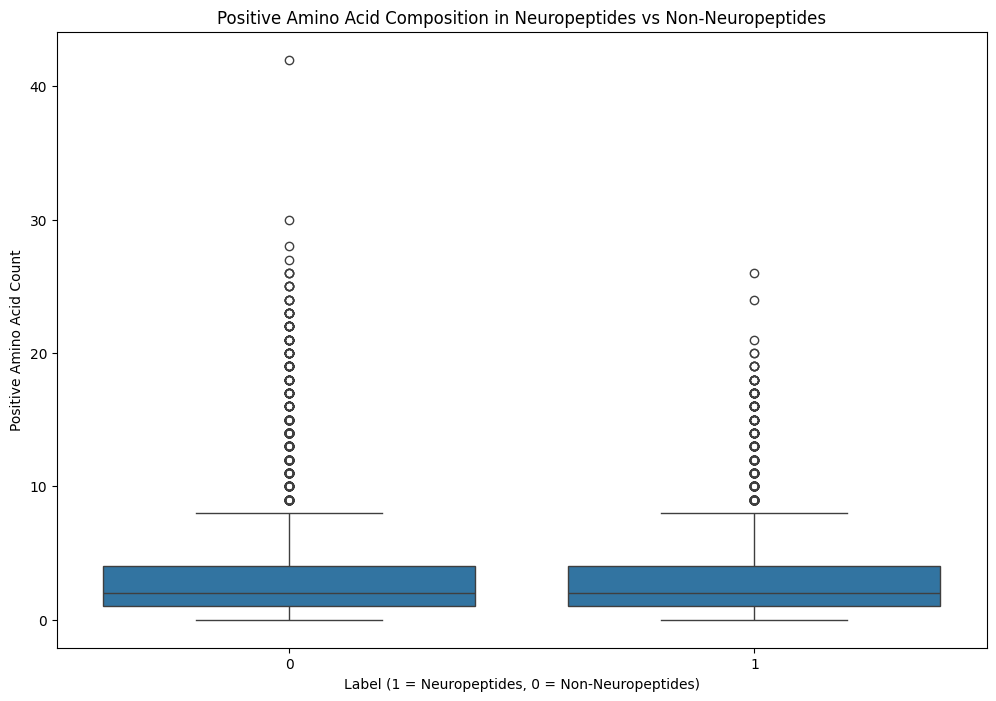

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_df, x='label', y='positive')
plt.title('Positive Amino Acid Composition in Neuropeptides vs Non-Neuropeptides')
plt.xlabel('Label (1 = Neuropeptides, 0 = Non-Neuropeptides)')
plt.ylabel('Positive Amino Acid Count')
plt.show()

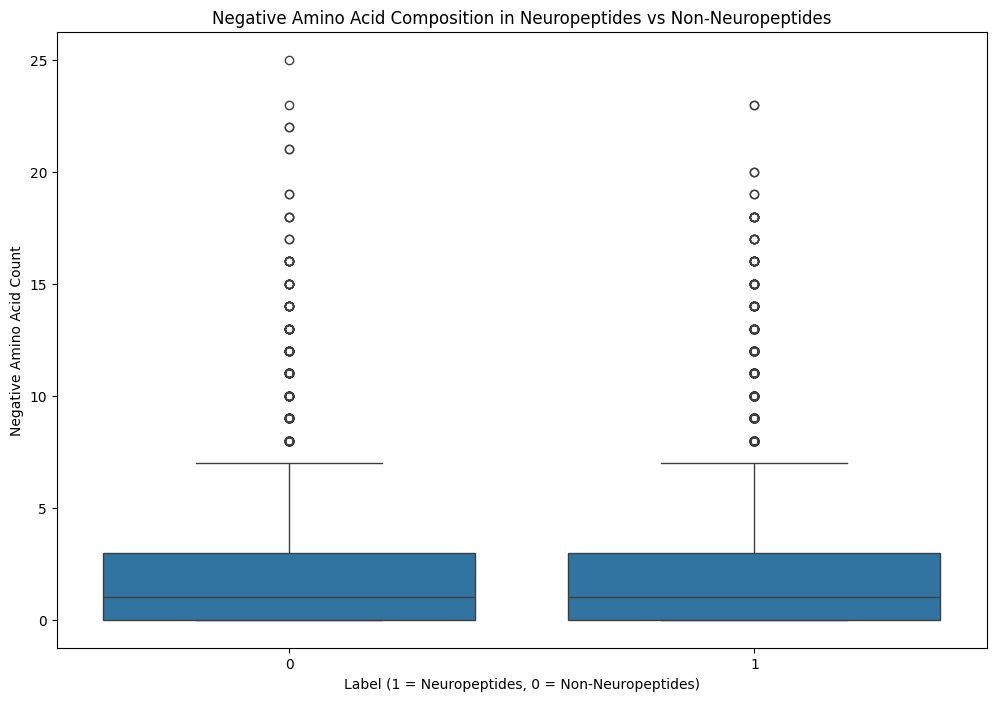

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_df, x='label', y='negative')
plt.title('Negative Amino Acid Composition in Neuropeptides vs Non-Neuropeptides')
plt.xlabel('Label (1 = Neuropeptides, 0 = Non-Neuropeptides)')
plt.ylabel('Negative Amino Acid Count')
plt.show()

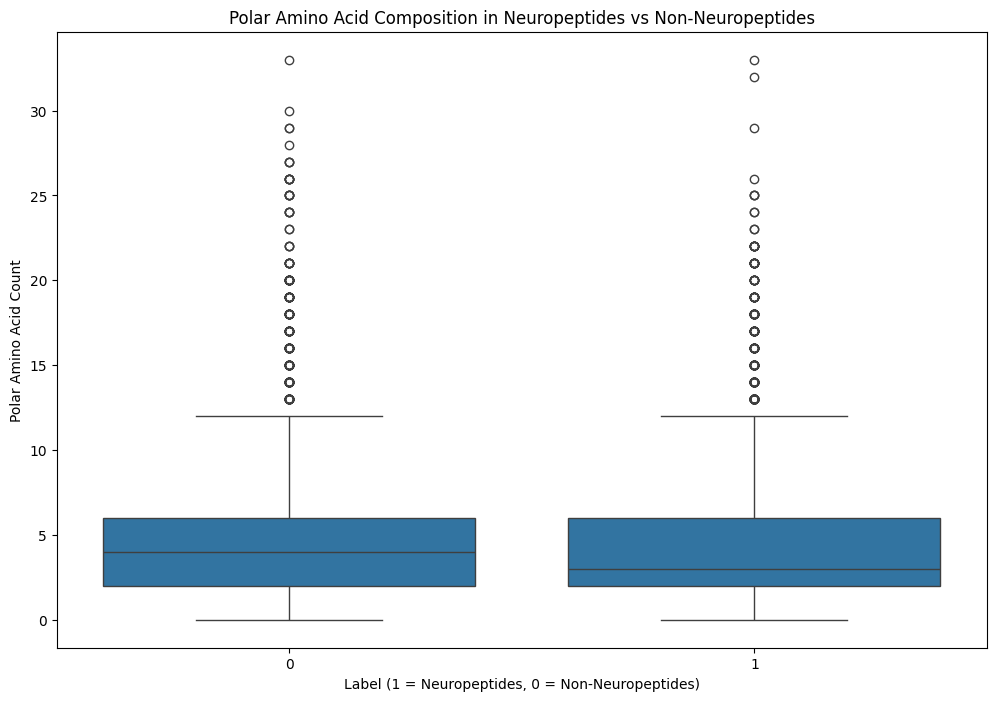

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_df, x='label', y='polar')
plt.title('Polar Amino Acid Composition in Neuropeptides vs Non-Neuropeptides')
plt.xlabel('Label (1 = Neuropeptides, 0 = Non-Neuropeptides)')
plt.ylabel('Polar Amino Acid Count')
plt.show()

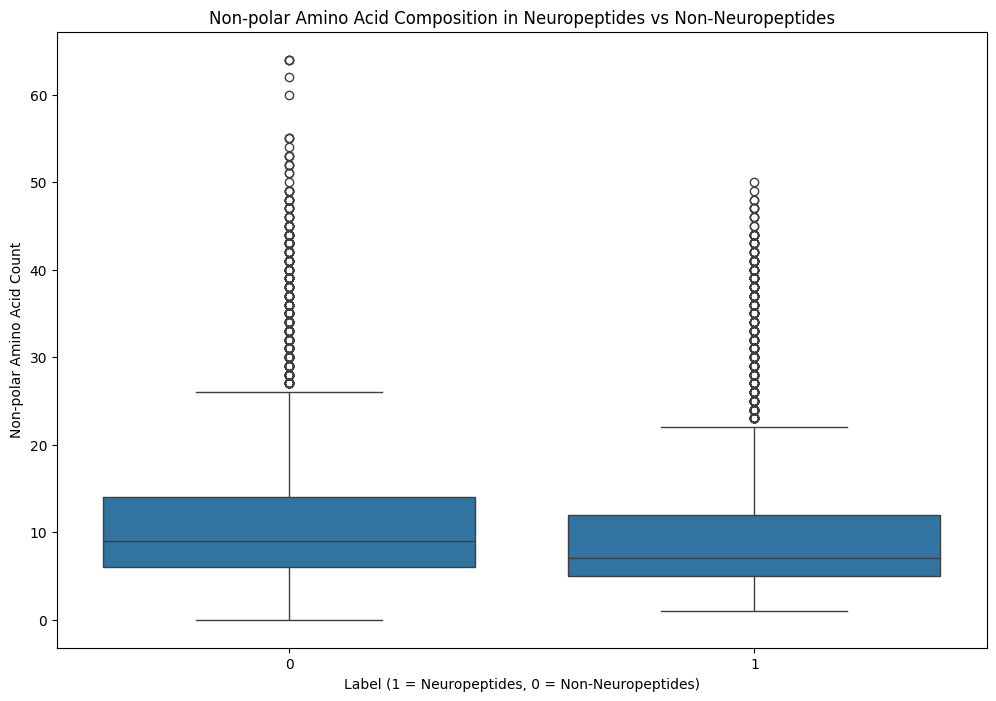

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_df, x='label', y='non_polar')
plt.title('Non-polar Amino Acid Composition in Neuropeptides vs Non-Neuropeptides')
plt.xlabel('Label (1 = Neuropeptides, 0 = Non-Neuropeptides)')
plt.ylabel('Non-polar Amino Acid Count')
plt.show()

In [ ]:
# Function to extract N-terminal and C-terminal amino acids
def terminal_composition(sequence, n=5):
    n_terminal = sequence[:n]  # First n residues
    c_terminal = sequence[-n:] # Last n residues
    return {'n_terminal': n_terminal, 'c_terminal': c_terminal}

# Apply the function to your dataset
train_df['terminals'] = train_df['sequence'].apply(lambda seq: terminal_composition(seq))

# Expand into separate columns
terminal_df = pd.json_normalize(train_df['terminals'])
train_df = pd.concat([train_df, terminal_df], axis=1)

# Analyze N-terminal and C-terminal composition differences
n_terminal_counts = train_df['n_terminal'].apply(lambda x: Counter(x))
c_terminal_counts = train_df['c_terminal'].apply(lambda x: Counter(x))

# Convert to a DataFrame for visualization (Example for N-terminal)
n_terminal_df = pd.DataFrame(list(n_terminal_counts))
n_terminal_df = n_terminal_df.fillna(0)

In [ ]:
train_df

,id,sequence,label,length,cluster,group_composition,hydrophobic,hydrophilic,positive,negative,polar,non_polar,terminals,n_terminal,c_terminal
0,PLM_pos,IKDNFIRF,1,8,1,"{'hydrophobic': 4, 'hydrophilic': 4, 'positive...",4,4,2,1,1,4,"{'n_terminal': 'IKDNF', 'c_terminal': 'NFIRF'}",IKDNF,NFIRF
1,PLM_pos,QERRAMGFVGMR,1,12,1,"{'hydrophobic': 5, 'hydrophilic': 5, 'positive...",5,5,3,1,1,7,"{'n_terminal': 'QERRA', 'c_terminal': 'FVGMR'}",QERRA,FVGMR
2,PLM_pos,APVSTGAGGGTVLAKMYPRGSHWAVGHLM,1,29,1,"{'hydrophobic': 13, 'hydrophilic': 2, 'positiv...",13,2,4,0,4,20,"{'n_terminal': 'APVST', 'c_terminal': 'VGHLM'}",APVST,VGHLM
3,PLM_pos,SYSMEHFRWGKPVGRKRRPVKVYTSNGVEEESAEVFPGEM,1,40,0,"{'hydrophobic': 13, 'hydrophilic': 14, 'positi...",13,14,8,6,6,18,"{'n_terminal': 'SYSME', 'c_terminal': 'FPGEM'}",SYSME,FPGEM
4,PLM_pos,RGPSGPLRFG,1,10,1,"{'hydrophobic': 2, 'hydrophilic': 2, 'positive...",2,2,2,0,1,7,"{'n_terminal': 'RGPSG', 'c_terminal': 'PLRFG'}",RGPSG,PLRFG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8033,PLM_neg,RVLEPGXEDPDVGEPAGEYEHHLLEX,0,26,1,"{'hydrophobic': 7, 'hydrophilic': 9, 'positive...",7,9,3,8,0,12,"{'n_terminal': 'RVLEP', 'c_terminal': 'HLLEX'}",RVLEP,HLLEX
8034,PLM_neg,MSSAILYRNK,0,10,1,"{'hydrophobic': 5, 'hydrophilic': 3, 'positive...",5,3,2,0,3,4,"{'n_terminal': 'MSSAI', 'c_terminal': 'LYRNK'}",MSSAI,LYRNK
8035,PLM_neg,NAHNFPLDLGAIEAPSTTG,0,19,0,"{'hydrophobic': 7, 'hydrophilic': 4, 'positive...",7,4,1,2,5,11,"{'n_terminal': 'NAHNF', 'c_terminal': 'PSTTG'}",NAHNF,PSTTG
8036,PLM_neg,MCVCGVHH,0,8,1,"{'hydrophobic': 3, 'hydrophilic': 0, 'positive...",3,0,2,0,0,4,"{'n_terminal': 'MCVCG', 'c_terminal': 'CGVHH'}",MCVCG,CGVHH


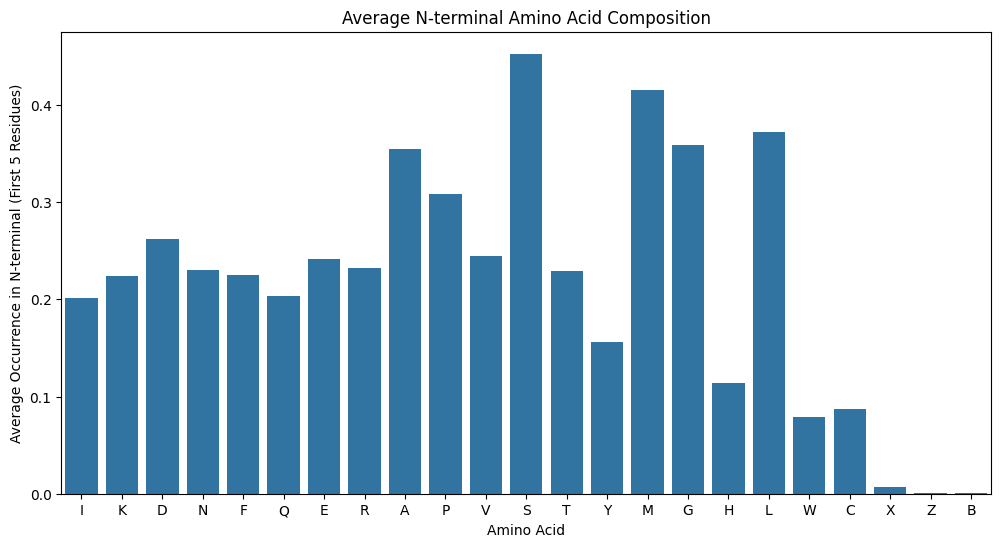

In [ ]:
# Plot average N-terminal composition for neuropeptides vs non-neuropeptides
plt.figure(figsize=(12, 6))
sns.barplot(data=n_terminal_df.mean().reset_index(), x='index', y=0)
plt.title('Average N-terminal Amino Acid Composition')
plt.xlabel('Amino Acid')
plt.ylabel('Average Occurrence in N-terminal (First 5 Residues)')
plt.show()

In [ ]:
# Function to replace non-standard amino acids with valid substitutes
def replace_invalid_amino_acids(sequence):
    replacements = {
        'X': 'A',  # Replace 'X' with Alanine
        'Z': 'E',  # Replace 'Z' with Glutamic Acid
        'B': 'D',  # Replace 'B' with Aspartic Acid
        'J': 'L',  # Replace 'J' with Leucine
        'U': 'C'   # Replace 'U' with Cysteine
    }
    for invalid_aa, valid_aa in replacements.items():
        sequence = sequence.replace(invalid_aa, valid_aa)
    return sequence

# Apply the function to dataset
train_df['sequence_replace'] = train_df['sequence'].apply(replace_invalid_amino_acids)

In [ ]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import molecular_weight

# Function to compute molecular weight and isoelectric point for a sequence
def compute_physicochemical(sequence):
    analysed_seq = ProteinAnalysis(sequence)
    return {
        'molecular_weight': molecular_weight(sequence, seq_type='protein'),
        'isoelectric_point': analysed_seq.isoelectric_point()  # Corrected function usage
    }

# Apply the function to your dataset
train_df['physicochemical'] = train_df['sequence_replace'].apply(compute_physicochemical)

# Expand into separate columns
physicochemical_df = pd.json_normalize(train_df['physicochemical'])
train_df = pd.concat([train_df, physicochemical_df], axis=1)

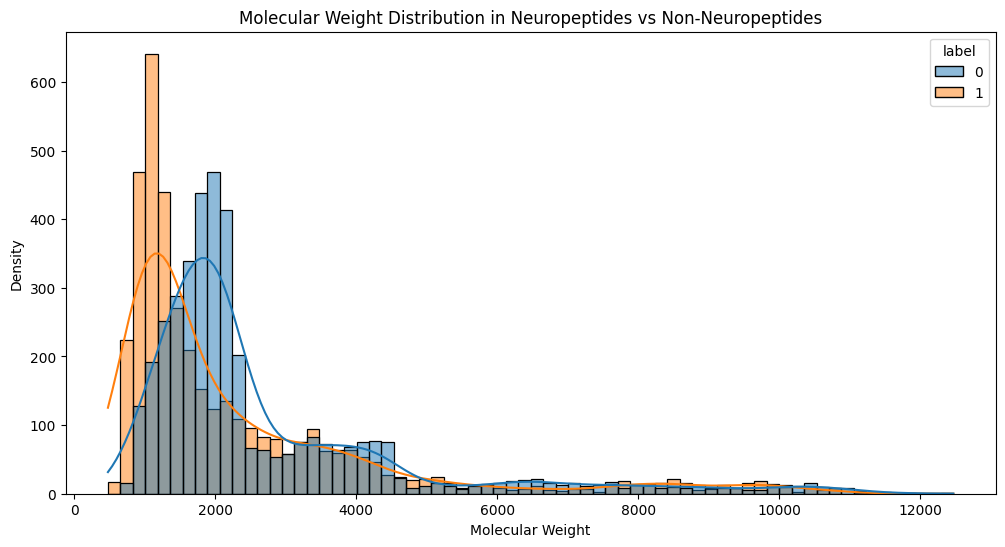

In [ ]:
# Visualize the distribution of molecular weight
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='molecular_weight', hue='label', kde=True)
plt.title('Molecular Weight Distribution in Neuropeptides vs Non-Neuropeptides')
plt.xlabel('Molecular Weight')
plt.ylabel('Density')
plt.show()

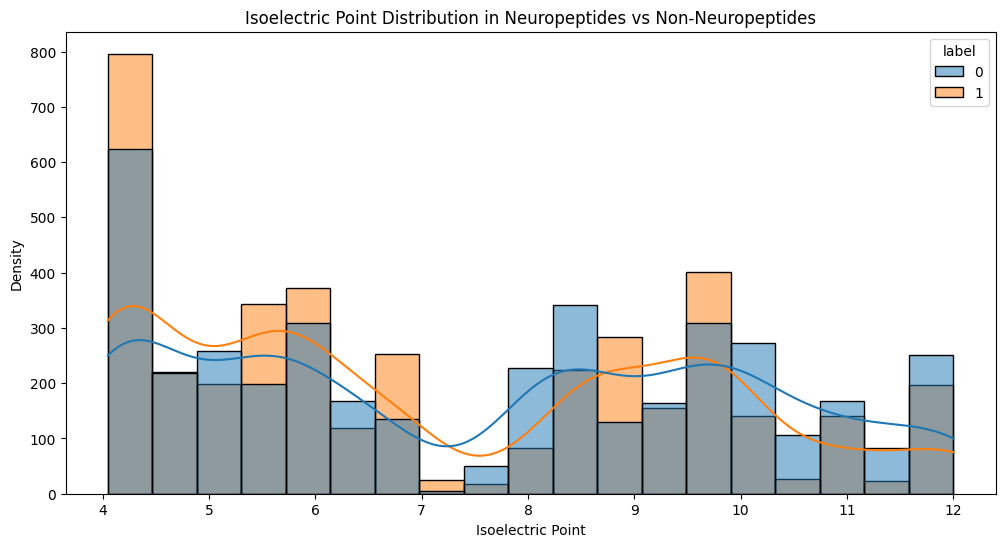

In [ ]:
# Visualize the distribution of molecular weight
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='isoelectric_point', hue='label', kde=True)
plt.title('Isoelectric Point Distribution in Neuropeptides vs Non-Neuropeptides')
plt.xlabel('Isoelectric Point')
plt.ylabel('Density')
plt.show()

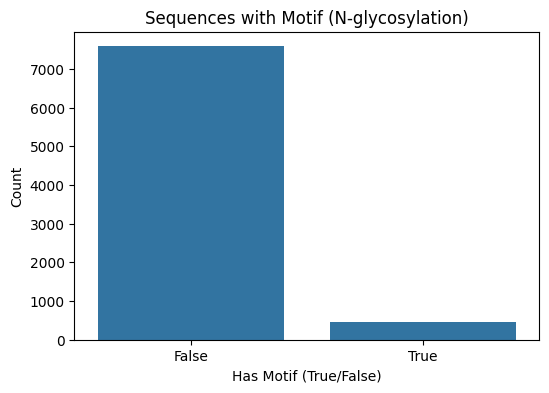

In [ ]:
import re

# Example: Motif search for a pattern (e.g., N-glycosylation motif N-{P}-[ST]-{P})
def search_motif(sequence, pattern="N[^P][ST][^P]"):
    return bool(re.search(pattern, sequence))

# Apply motif search
train_df['has_motif'] = train_df['sequence'].apply(search_motif)

# Count the number of sequences with the motif
motif_counts = train_df['has_motif'].value_counts()

# Visualize
plt.figure(figsize=(6, 4))
sns.barplot(x=motif_counts.index, y=motif_counts.values)
plt.title('Sequences with Motif (N-glycosylation)')
plt.xlabel('Has Motif (True/False)')
plt.ylabel('Count')
plt.show()

## Train

In [ ]:
train_features = extract_esm_features(train_df)
test_features = extract_esm_features(test_df)

100%|██████████| 89/89 [00:26<00:00,  3.35it/s]


In [ ]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Create a PyTorch Dataset class
class PeptideDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Prepare datasets
train_dataset = PeptideDataset(train_features, train_df['label'].values)
test_dataset = PeptideDataset(test_features, test_df['label'].values)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
# Fine-tuning model: add a classification head
class ESMClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ESMClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, 2)  # Binary classification

    def forward(self, x):
        return self.fc(x)

In [ ]:
# Training the classifier
def train_model(model, train_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Initialize and train the model
model = ESMClassifier(input_dim=train_features.shape[1])
train_model(model, train_loader)

Epoch 1, Loss: 0.3328823242971294
Epoch 2, Loss: 0.261344565347356
Epoch 3, Loss: 0.2422198726898708
Epoch 4, Loss: 0.23053439479889998
Epoch 5, Loss: 0.2233036797685984
Epoch 6, Loss: 0.21922953871738476
Epoch 7, Loss: 0.2130801879123794
Epoch 8, Loss: 0.21023578133054116
Epoch 9, Loss: 0.20719760197159182
Epoch 10, Loss: 0.20301090049344828


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Function to get predictions from the model
def get_predictions(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Get predictions and true labels
test_preds, test_labels = get_predictions(model, test_loader)

In [ ]:
# Accuracy
accuracy = accuracy_score(test_labels, test_preds)
# Precision
precision = precision_score(test_labels, test_preds)
# Recall
recall = recall_score(test_labels, test_preds)
# F1-Score
f1 = f1_score(test_labels, test_preds)
# ROC-AUC score
roc_auc = roc_auc_score(test_labels, test_preds)

# Print out the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.9099
Precision: 0.9136
Recall: 0.9054
F1 Score: 0.9095
ROC-AUC: 0.9099


In [ ]:
# Classification report
report = classification_report(test_labels, test_preds, target_names=['Non-Neuropeptide', 'Neuropeptide'])
print(report)

                  precision    recall  f1-score   support

Non-Neuropeptide       0.91      0.91      0.91       444
    Neuropeptide       0.91      0.91      0.91       444

        accuracy                           0.91       888
       macro avg       0.91      0.91      0.91       888
    weighted avg       0.91      0.91      0.91       888



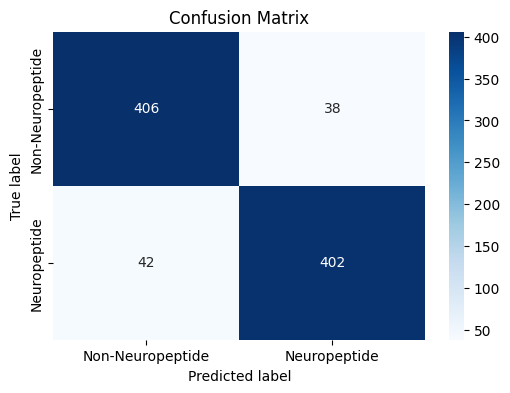

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Non-Neuropeptide', 'Neuropeptide'], yticklabels=['Non-Neuropeptide', 'Neuropeptide'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# sharp

In [ ]:
!pip -q install shap

In [ ]:
import shap
import torch
from tqdm import tqdm

shap.initjs()

# Initialize SHAP explainer
explainer = shap.DeepExplainer(model, torch.tensor(train_features))

# Calculate SHAP values for the test set with progress tracking
shap_values = explainer.shap_values(torch.tensor(test_features))

In [ ]:
explainer.expected_value.shape

(2,)

In [ ]:
shap_values.shape, test_features.shape

((888, 1280, 2), (888, 1280))

In [ ]:
shap_values[0].shape, test_features[0].shape

((1280, 2), (1280,))

In [ ]:
shap_values.T[0].shape, test_features.T.shape

((1280, 888), (1280, 888))

In [ ]:
shap_values[0].T[0].shape, test_features[0].T.shape

((1280,), (1280,))

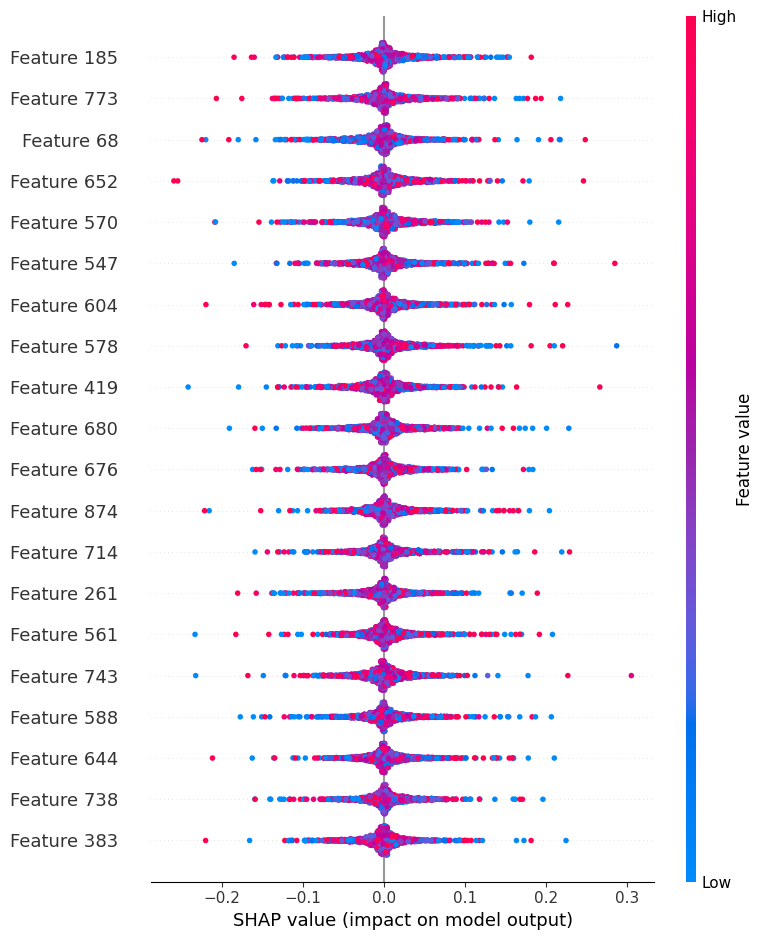

In [ ]:
# Create summary plot for feature importance
shap.summary_plot(shap_values.T[0], test_features.T)

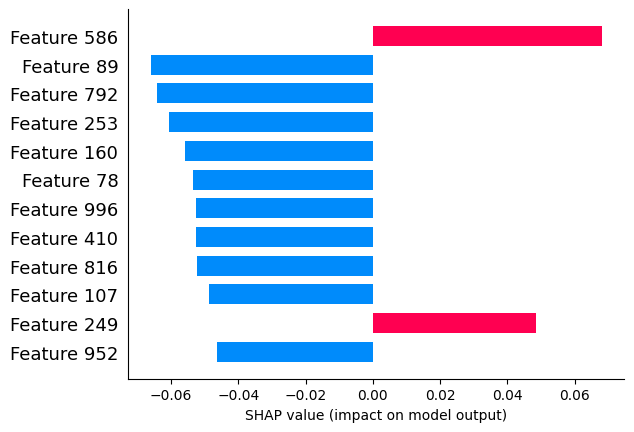

In [ ]:
shap.bar_plot(shap_values[0].T[0], max_display=12)

In [ ]:
shap.save_html("force_plot_0_0.html", shap.force_plot(explainer.expected_value[0], shap_values[0].T[0], test_features[0], feature_names=feature_names, link='logit'))
shap.save_html("force_plot_1_0.html", shap.force_plot(explainer.expected_value[1], shap_values[0].T[1], test_features[0], feature_names=feature_names, link='logit'))

In [ ]:
shap.save_html("force_plot_0_26.html", shap.force_plot(explainer.expected_value[0], shap_values[26].T[0], test_features[26], feature_names=feature_names, link='logit'))
shap.save_html("force_plot_1_26.html", shap.force_plot(explainer.expected_value[1], shap_values[26].T[1], test_features[26], feature_names=feature_names, link='logit'))

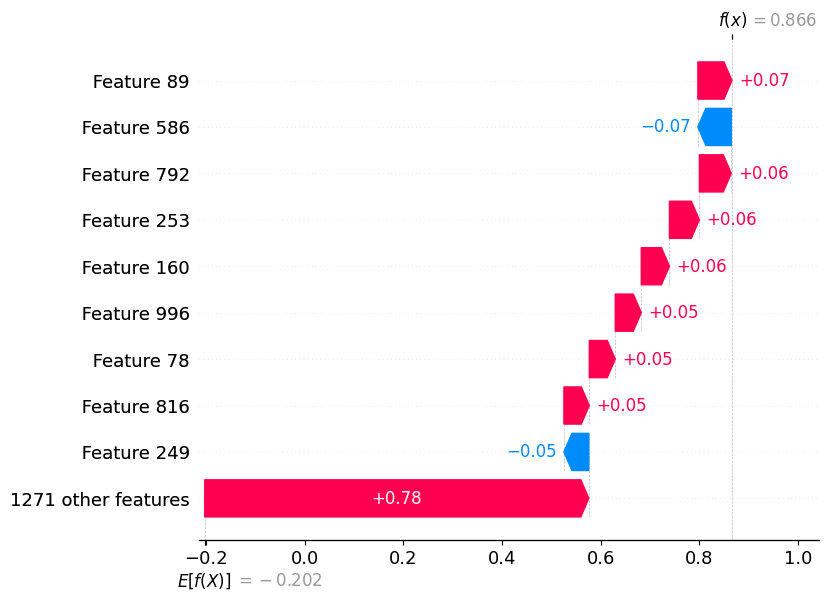

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[0].T[1], test_features[0])

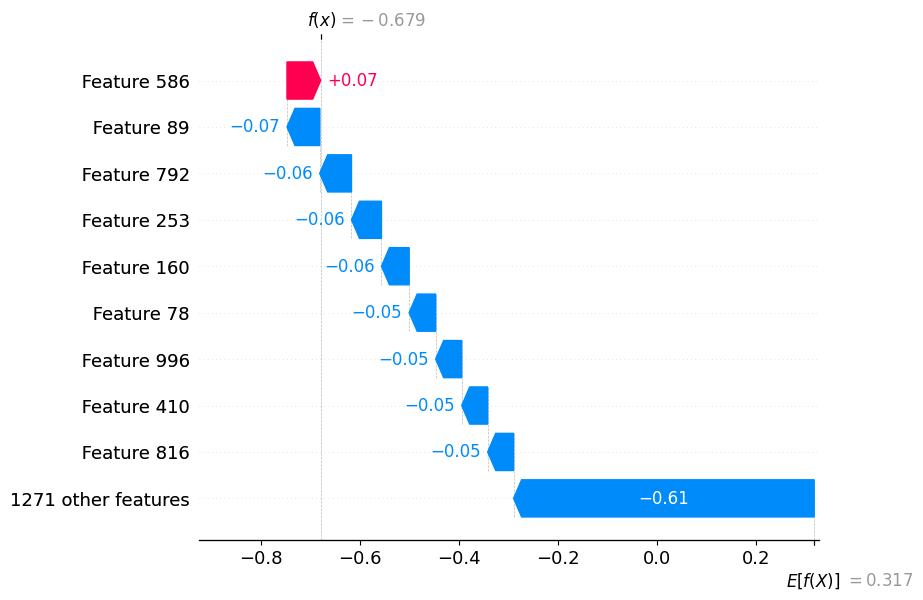

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0].T[0], test_features[26])

In [ ]:
feature_names = [f"Feature {i}" for i in range(test_features.shape[1])]

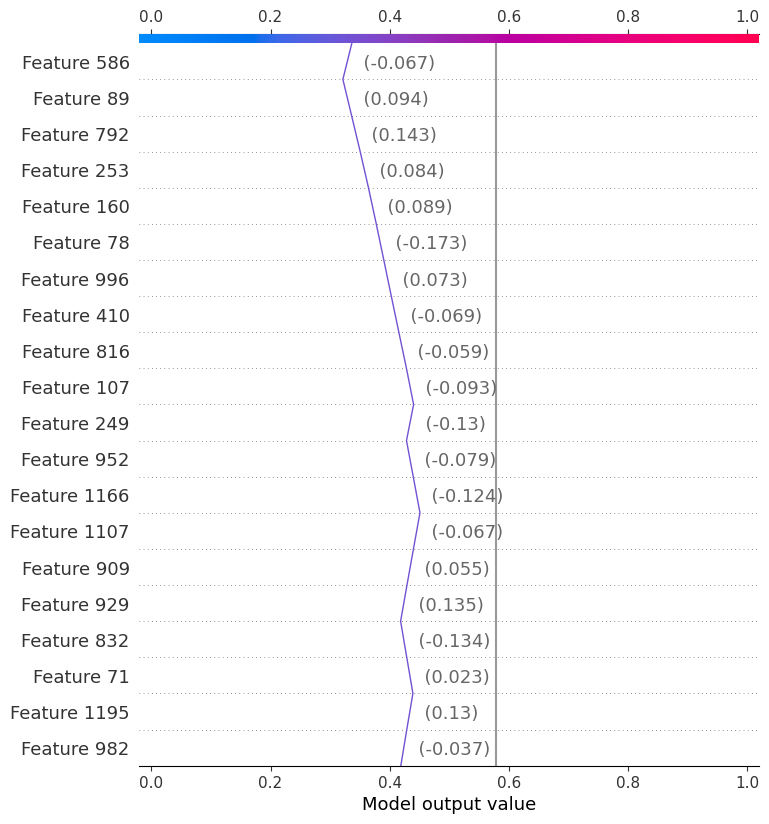

In [ ]:
shap.decision_plot(explainer.expected_value[0], shap_values[0].T[0], test_features[0], feature_names=feature_names, link='logit')

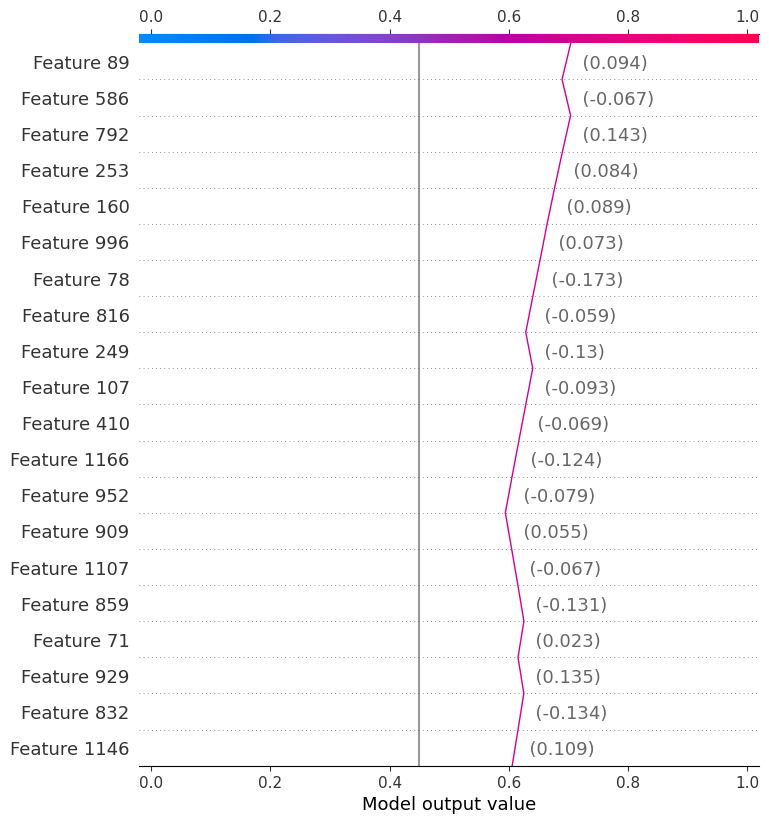

In [ ]:
shap.decision_plot(explainer.expected_value[1], shap_values[0].T[1], test_features[0], feature_names=feature_names, link='logit')

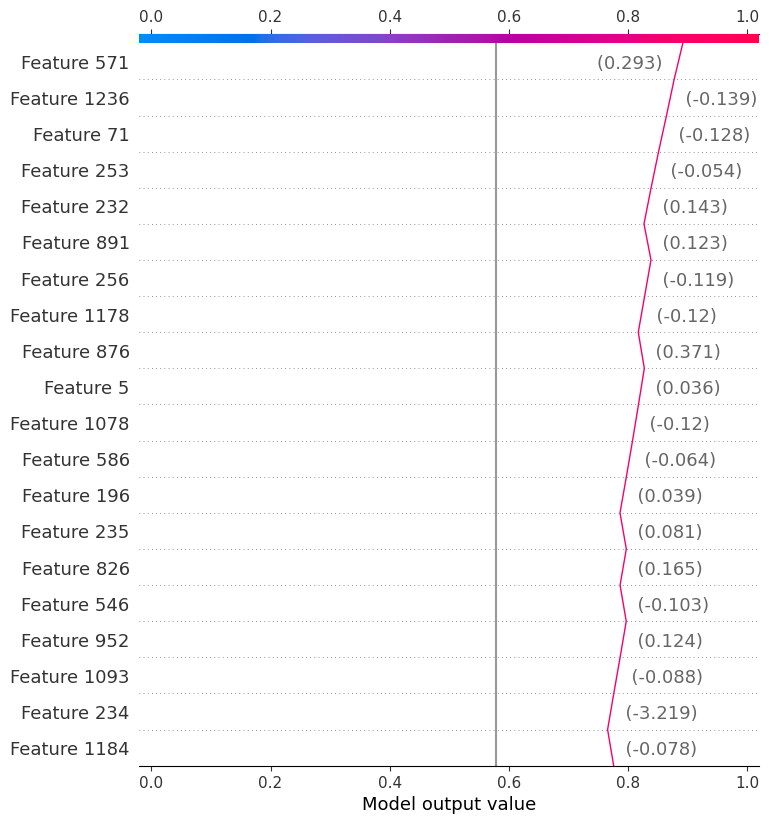

In [ ]:
shap.decision_plot(explainer.expected_value[0], shap_values[26].T[0], test_features[26], feature_names=feature_names, link='logit')

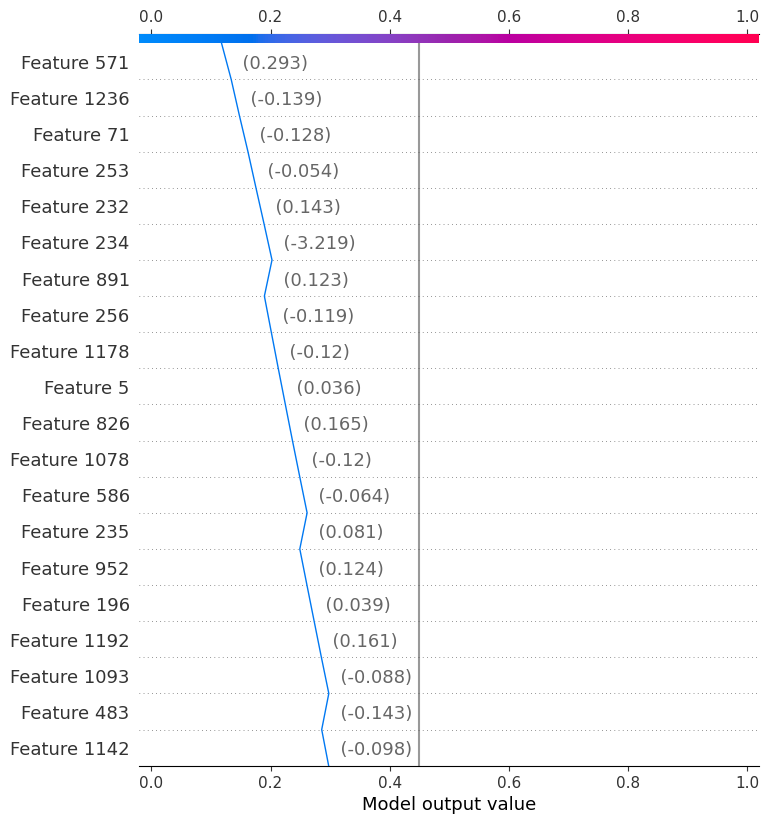

In [ ]:
shap.decision_plot(explainer.expected_value[1], shap_values[26].T[1], test_features[26], feature_names=feature_names, link='logit')